In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as modsel
from sklearn.preprocessing import StandardScaler

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

import sklearn.model_selection as modsel    
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data = pd.read_parquet('pump_station_data.parquet')

In [8]:
#----------------------------------Pump 1 RPM limtited time frame model data--------------------------------------
# Optimal for Pump 1 is, for the limited time model, n_tems = 6, ylag = 2, xlag = 5. rrse =  0.27
'''
data = data[:]['2023-02-14 12:27:00':'2023-02-14 14:50:00']    
data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)

x_train = data_train['pump1_rpm'].values.reshape(-1,1)                 
y_train = data_train['outflow'].values.reshape(-1,1)

x_test = data_test['pump1_rpm'].values.reshape(-1,1)                    
y_test = data_test['outflow'].values.reshape(-1,1)
'''

#----------------------------------Pump 4 RPM limtited time frame model data--------------------------------------
# Optimal for Pump 4 is, for the limited time model, n_tems = 4, ylag = 2, xlag = 18. rrse =  0.28
'''
data = data[:]['2023-02-14 10:00:00':'2023-02-14 12:20:00']     
data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)

x_train = data_train['pump4_rpm'].values.reshape(-1,1)          
y_train = data_train['outflow'].values.reshape(-1,1)

x_test = data_test['pump4_rpm'].values.reshape(-1,1)            
y_test = data_test['outflow'].values.reshape(-1,1)
'''

#----------------------------------Pump RPM model--------------------------------------
# Optimal for Pump 4 is, for the limited time model, n_tems = 6, ylag = 2, xlag = 6. rrse =  0.179
# More parameters xlag_first = 5, rrse = 0.178


#data = data[:]['2023-02-14 10:00:00':'2023-02-14 14:50:00'] # Data for short time model
#data = data[:]['2023-02-12 00:01:00':'2023-02-15 23:59:00'] # Data for longer time model
data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)

data_train = data[:]['2023-02-14 10:00:00':'2023-02-14 13:00:00'].resample("10s").mean()
x_train = data_train.drop(labels=['height','outflow', 'pump1_power', 'pump4_power'], axis=1)
x_train = x_train.to_numpy()      
y_train = data_train['outflow'].values.reshape(-1,1)


data_test = data[:]['2023-02-14 13:00:00':'2023-02-14 14:00:00'].resample("10s").mean()

x_test = data_test.drop(labels=['height','outflow', 'pump1_power', 'pump4_power'], axis=1)
x_test = x_test.to_numpy()        
y_test = data_test['outflow'].values.reshape(-1,1)


# height estimation
'''
x_train = data_train.drop(labels=['pump1_power', 'pump4_power','pump1_rpm','pump4_rpm','height'], axis=1)
x_train = x_train.to_numpy()      
y_train = data_train['height'].values.reshape(-1,1)
data_train = data[:]['2023-02-14 10:00:00':'2023-02-14 14:50:00']

x_test = data_test.drop(labels=['pump1_power', 'pump4_power','pump1_rpm','pump4_rpm','height'], axis=1)
x_test = x_test.to_numpy()        
y_test = data_test['height'].values.reshape(-1,1)
data_test = data[:]['2023-02-14 15:00:00':'2023-02-14 20:00:00'] # Data for short time model
'''


"\nx_train = data_train.drop(labels=['pump1_power', 'pump4_power','pump1_rpm','pump4_rpm','height'], axis=1)\nx_train = x_train.to_numpy()      \ny_train = data_train['height'].values.reshape(-1,1)\ndata_train = data[:]['2023-02-14 10:00:00':'2023-02-14 14:50:00']\n\nx_test = data_test.drop(labels=['pump1_power', 'pump4_power','pump1_rpm','pump4_rpm','height'], axis=1)\nx_test = x_test.to_numpy()        \ny_test = data_test['height'].values.reshape(-1,1)\ndata_test = data[:]['2023-02-14 15:00:00':'2023-02-14 20:00:00'] # Data for short time model\n"

In [17]:
# The model is fitted 
basis_function= Polynomial(degree=1)
rrse_low = 1
nt_yl_xl_best = []
yhat_best = []
for nt in range(2,7):
    for yl in range(1,4):
        for xl in range(1,20):
                model = FROLS(
                    order_selection=True,
                    n_terms = nt,
                    extended_least_squares=False,
                    ylag=yl,
                    xlag=[[1, xl],[1, xl]],
                    info_criteria="aic",
                    estimator="least_squares",
                    basis_function=basis_function,
                    )

                model.fit(X=x_train, y=y_train)
                yhat = model.predict(X=x_test,y=y_test,forecast_horizon=400)
                rrse = root_relative_squared_error(y_test, yhat)
                if rrse < rrse_low:
                    rrse_low = rrse
                    yhat_best = yhat
                    nt_yl_xl_best = [nt,yl,xl]



In [15]:
# The model is fitted 
basis_function= Polynomial(degree=1)

model = FROLS(
    order_selection=True,
    n_terms = 6,
    extended_least_squares=False,
    ylag=2,
    xlag=[[1, 6],[1, 6]],
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
    )

model.fit(X=x_train, y=y_train)
#yhat = model.predict(X=x_test,y=y_test,forecast_horizon=400)
yhat = model.predict(X=x_test,y=y_test,forecast_horizon=400)
rrse = root_relative_squared_error(y_test, yhat)
print(rrse)


0.2570724868159431


In [18]:
print(nt_yl_xl_best)
print(rrse_low)

[6, 2, 7]
0.2568709637498524


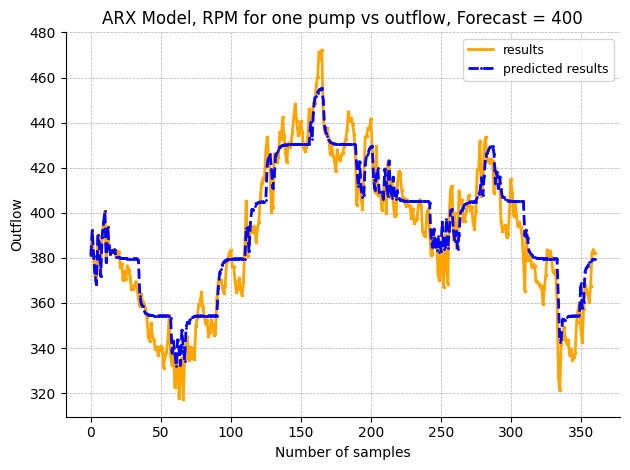

In [19]:

fig, ax = plt.subplots()
ax.plot(y_test[:500], color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='results')
ax.plot(yhat[:500],color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='predicted results')
ax.set_title(f"ARX Model, RPM for one pump vs outflow, Forecast = 400")
ax.set_xlabel(f"Number of samples")
ax.set_ylabel("Outflow")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)
# set x ticks
ax.xaxis.get_major_ticks()
# Adding a legend
plt.legend(fontsize=9)
# Adjusting the layout
plt.tight_layout()
plt.show()


mse = 95.5384431338806


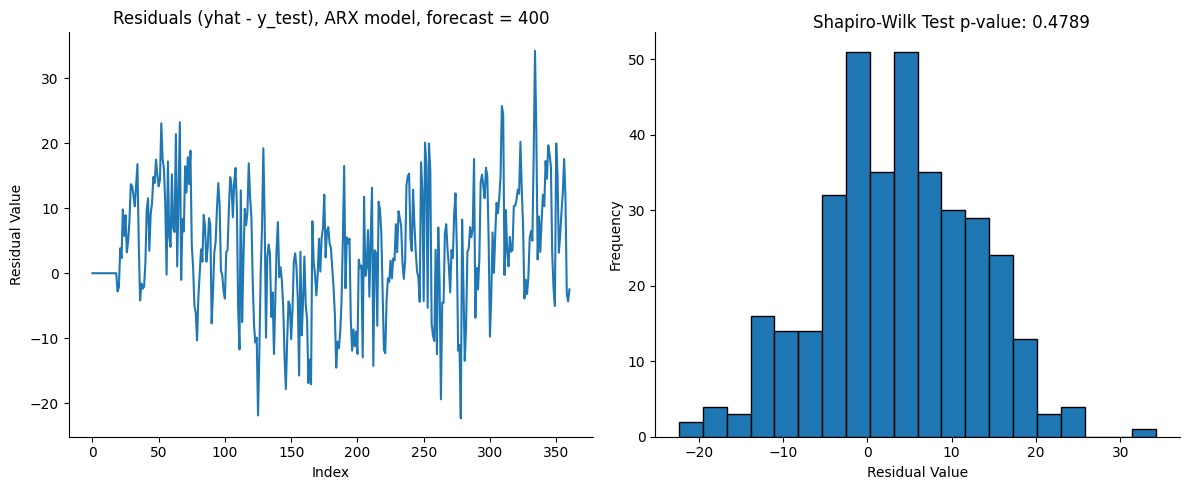

Shapiro-Wilk Test result:
Statistic: 0.9959, p-value: 0.4789


In [21]:
from scipy.stats import shapiro


residuals = yhat - y_test

# Calculate the mean squared error
mse = np.mean((residuals) ** 2)
print("mse =",mse)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test), ARX model, forecast = 400')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')

# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

In [14]:
alpha = 0.05  # significance level
if p > alpha:
    print("The Shapiro-Wilk test is successful: the data follows a normal distribution.")
else:
    print("The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.")

The Shapiro-Wilk test is successful: the data follows a normal distribution.
